In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time

from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sonnet as snt
import tensorflow as tf

from data_processing_utils import *
from NLNN import *
 
SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Data

The dataset consists of fMRI time-series activations 
- 300 ROIs: schafer 300 ROI parcellation,
- 176 participants,
- each participant watches 15 movie clips.

In [2]:
videoclip_table = pd.read_csv("data/videoclip_tr_lookup.csv")
videoclip_table

,clipno_overall,run,clipno_in_run,clip_name,start_tr,stop_tr
0,1,MOVIE1_7T_AP,1,twomen,20.0000,264.0417
1,2,MOVIE1_7T_AP,2,bridgeville,284.0833,505.7083
2,3,MOVIE1_7T_AP,3,pockets,525.7500,713.7500
3,4,MOVIE1_7T_AP,4,overcome,733.7917,797.5417
4,5,MOVIE1_7T_AP,5,testretest1,817.5833,900.9583
5,6,MOVIE2_7T_PA,1,inception,20.0000,246.7083
6,7,MOVIE2_7T_PA,2,socialnet,266.7500,525.3333
7,8,MOVIE2_7T_PA,3,oceans,545.3750,794.5833
8,9,MOVIE2_7T_PA,4,testretest2,814.5833,897.9583
9,10,MOVIE3_7T_PA,1,flower,20.0000,200.5417


**In our dataset, each data sample is represented as a graph**  
- each ROI is a node, i.e. we have 300 nodes in the graph
- attribute of each node is its entire time-series
- all nodes are connected pair wise
- there is **no** edge attribute

In [3]:
# Load dataset 
X, X_len, clip_y, num_subjs, num_clips = get_data()

# Pad each time-series with zeros to equalize lengths
X = pad_data(X)

# Create graphs from data
graphs_tuple = clip_graphs(X)

# Convert clip labels to one-hot vectors
clip_y_oh = tf.one_hot(clip_y, num_clips).numpy()

# Train, validation, test split
num_train = 90 * num_clips
num_val = 10 * num_clips
num_test = 76 * num_clips

train_G, train_y, val_G, val_y, test_G, test_y = train_val_test_split(graphs_tuple,
                                                                       clip_y_oh,
                                                                       num_train,
                                                                       num_val,
                                                                       num_test,
                                                                       num_clips,
                                                                       num_subjs)

loading run 1/4
loading run 2/4
loading run 3/4
loading run 4/4


# Model

<img src="NLNN.png">

- Non-local neural network (**NLNN**) is a variant of Graph Network.
- In our model, the **NLNN** takes as *input a graph* with node and edge attributes and *outputs a graph* with updated node attributes.

**NLNN algorithm**
1. For each edge $k$ in the input graph,  

    - compute updated edge attributes  
    $\textbf{e}_{k}^{\prime} = \phi^{e} \left( \left[ \textbf{v}_{s_k}, \textbf{v}_{r_k} \right] \right)$,  
    where $\textbf{v}_{s_k}, \textbf{v}_{r_k}$ are sender and receiver nodes attributes resp. of edge $k$,  
    $\left[ \cdot, \cdot \right]$ denotes concatenation of attributes.  
    
2. For each vertex $i$ in the input graph,  

    - aggregate attributes of all edges adjacent to node $i$  
    $\bar{\textbf{e}}_{i}^{\prime} = \rho^{e \rightarrow v} \left( \textbf{E}_{i}^{\prime} \right)$,  
    where $\textbf{E}_{i}^{\prime}$ is set of received and sent edge attributes.  
    
    - compute updated node attributes    
    $\textbf{v}_{i}^{\prime} = \phi^{v} \left( \left[ \textbf{v}_{i}, \bar{\textbf{e}}_{i}^{\prime} \right] \right)$.  
    
**Update functions**
1. $\phi^{e}$: Single Layer Perceptron with output attribute size 16.  
2. $\phi^{v}$: Single Layer Perceptron with output attribute size 16.  

**Aggregate functions**
1. $\rho^{e \rightarrow v}$: summation.


In [4]:
# Create model
model = NLNNClassifer(num_nodes=300, 
                      k_linear=16, 
                      num_classes=num_clips)

# Define loss and gradient functions
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

def loss(model, x, y):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x)
  return loss_object(y_true=y, y_pred=y_)

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Performance evaluation

In [5]:
train_loss_results = []
train_accuracy_results = []
val_loss_results = []
val_accuracy_results = []

template = ("Epoch {:03d}: " 
            "Train Loss: {:.3f}, " 
            "Train Accuracy: {:.3%}, " 
            "Validation Loss: {:.3f}, "
            "Validation Accuracy: {:.3%}")

num_epochs = 10
batch_size = 8

for epoch in range(num_epochs):
    train_loss_avg = tf.keras.metrics.Mean()
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    val_loss_avg = tf.keras.metrics.Mean()
    val_accuracy = tf.keras.metrics.CategoricalAccuracy()

    # Training loop - using batches of <batch_size>
    for i in range(0, num_train, batch_size):
        
        # Optimize the model
        x = utils_tf.get_graph(train_G, slice(i, i + batch_size))
        y = train_y[i : i + batch_size, :]
        loss_value, grads = grad(model, x, y)
        
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress: Add current batch loss
        train_loss_avg.update_state(loss_value)  
        # Compare predicted label to actual label
        train_accuracy.update_state(y, model(x))

    # Log training loss and accuracy
    train_loss_results.append(train_loss_avg.result())
    train_accuracy_results.append(train_accuracy.result())
    
    # Validation loop
    for i in range(0, num_val, batch_size):
        x = utils_tf.get_graph(val_G, slice(i, i + batch_size))
        y = val_y[i : i + batch_size, :]
        logits = model(x)
        
        # Track progress
        val_loss_value = loss(model, x, y)
        val_loss_avg.update_state(val_loss_value)
        val_accuracy.update_state(logits, y)
        
    # Log validation loss and accuracy
    val_loss_results.append(val_loss_avg.result())
    val_accuracy_results.append(val_accuracy.result())

    if epoch % 1 == 0:
        print(template.format(epoch,
                              train_loss_avg.result(),
                              train_accuracy.result(),
                              val_loss_avg.result(),
                              val_accuracy.result()))

Epoch 000: Train Loss: 26.554, Train Accuracy: 86.074%, Validation Loss: 8.571, Validation Accuracy: 90.667%
Epoch 001: Train Loss: 4.570, Train Accuracy: 98.074%, Validation Loss: 11.567, Validation Accuracy: 92.667%
Epoch 002: Train Loss: 2.408, Train Accuracy: 99.259%, Validation Loss: 6.732, Validation Accuracy: 93.333%
Epoch 003: Train Loss: 1.042, Train Accuracy: 99.704%, Validation Loss: 7.314, Validation Accuracy: 95.333%
Epoch 004: Train Loss: 1.144, Train Accuracy: 99.926%, Validation Loss: 5.460, Validation Accuracy: 95.333%
Epoch 005: Train Loss: 1.786, Train Accuracy: 99.778%, Validation Loss: 9.916, Validation Accuracy: 94.000%
Epoch 006: Train Loss: 2.713, Train Accuracy: 99.852%, Validation Loss: 11.185, Validation Accuracy: 92.667%
Epoch 007: Train Loss: 3.361, Train Accuracy: 99.704%, Validation Loss: 21.736, Validation Accuracy: 91.333%
Epoch 008: Train Loss: 3.997, Train Accuracy: 99.778%, Validation Loss: 16.459, Validation Accuracy: 92.667%
Epoch 009: Train Loss: 

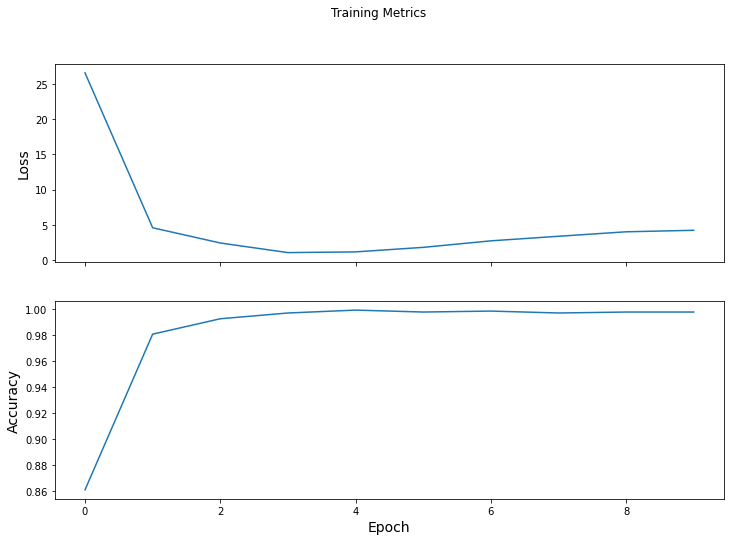

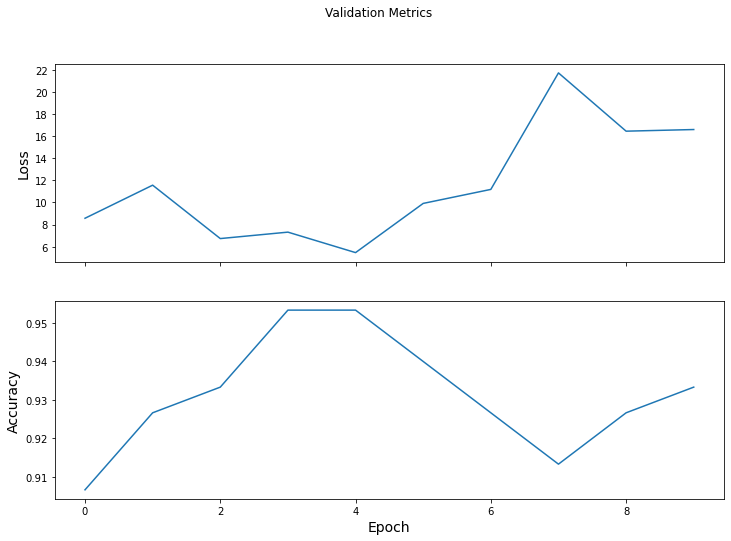

In [6]:
# Training metrics
fig_tr, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig_tr.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

# Validation metrics
fig_val, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig_val.suptitle('Validation Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(val_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(val_accuracy_results)
plt.show()

In [7]:
test_accuracy = tf.keras.metrics.CategoricalAccuracy()

for i in range(0, num_test, batch_size):
    x = utils_tf.get_graph(test_G, slice(i, i + batch_size))
    y = test_y[i : i + batch_size, :]
    logits = model(x)
    
    test_accuracy.update_state(logits, y)
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))


Test set accuracy: 93.421%
